In [1]:
%run batter_data.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import kerastuner as kt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
import skopt

from tensorflow import keras

feature, target = batter_data("LT")

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning: 
A va

In [3]:
feature.columns

Index(['RUN', 'H2', 'BB', 'MONEY_BAT', 'AGE_VA_BAT', 'K/PA', 'BABIP_BAT',
       'BPF', 'BS_PCA', 'PA_PCA', 'LB_PCA'],
      dtype='object')

In [22]:
trainFeature = feature.loc[0:feature.shape[0]-20]
trainTarget = target.loc[0:feature.shape[0]-20]

testFeature = feature.loc[feature.shape[0]-20:].reset_index(drop = True)
testTarget = target[feature.shape[0]-20:].reset_index(drop = True)
trainFeature.shape

(580, 13)

In [4]:
scaler = MinMaxScaler()
res = scaler.fit(trainFeature)
res = scaler.transform(trainFeature)
trainFeature = pd.DataFrame(res, columns = trainFeature.columns, index = list(trainFeature.index.values))

res = scaler.transform(validFeature)
validFeature = pd.DataFrame(res, columns = validFeature.columns, index = list(validFeature.index.values))

res = scaler.transform(testFeature)
testFeature = pd.DataFrame(res, columns = testFeature.columns, index = list(testFeature.index.values))

In [ ]:
class MCDropout(keras.layers.Dropout) :
    def call(self, inputs) :
        return super().call(inputs, training = True)
    
def make_model(hp) :
    model = keras.Sequential()

    model.add(keras.layers.Input(shape = (trainFeature.shape[1])))
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), 32, 512, 32),
                               activation="selu", kernel_initializer = "lecun_normal"))
        model.add(MCDropout(rate = hp.Choice("rate", values = [0.1, 0.2, 0.3, 0.4, 0.5])))

    model.add(keras.layers.Dense(1, activation = None))

    optimizer = keras.optimizers.Nadam(hp.Choice("learning_rate", values = [0.005, 0.001, 0.0005, 0.0001]))

    model.compile(optimizer = optimizer, loss = keras.losses.Huber())
    return model

tuner = kt.BayesianOptimization(make_model, objective = "val_loss", max_trials = 21, executions_per_trial = 11)
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 30, mode = "min", restore_best_weights = True)

tuner.search(trainFeature, trainTarget, epochs = 500, validation_data = (validFeature, validTarget), shuffle = False, use_multiprocessing = True, callbacks = [early_stop], batch_size = 20)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 480 samples, validate on 101 samples
Epoch 1/500
480/480 [==============================] - ETA: 30s - loss: 0.70 - ETA: 1s - loss: 0.6091 - ETA: 0s - loss: 0.595 - 2s 5ms/sample - loss: 0.5815 - val_loss: 0.3950
Epoch 2/500
480/480 [==============================] - ETA: 0s - loss: 0.286 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.386 - 0s 625us/sample - loss: 0.3940 - val_loss: 0.3608
Epoch 3/500
480/480 [==============================] - ETA: 0s - loss: 0.267 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.343 - 0s 621us/sample - loss: 0.3322 - val_loss: 0.3287
Epoch 4/500
480/480 [==============================] - ETA: 0s - loss: 0.213 - ETA: 0s - loss: 0.296 - ETA: 0s - loss: 0.287 - ETA: 0s - loss: 0.292 - 0s 663us/sample - loss: 0.2919 - val_loss: 0.2382
Epoch 5/500
480/480 [==============================] - ETA: 0s - loss: 0.263 - ETA: 0s - loss: 0.255 - ET

Train on 480 samples, validate on 101 samples
Epoch 1/500
480/480 [==============================] - ETA: 54s - loss: 3.49 - ETA: 5s - loss: 4.7902 - ETA: 2s - loss: 5.495 - ETA: 0s - loss: 5.427 - 4s 8ms/sample - loss: 5.1949 - val_loss: 4.3567
Epoch 2/500
480/480 [==============================] - ETA: 0s - loss: 8.807 - ETA: 0s - loss: 3.991 - ETA: 0s - loss: 3.468 - ETA: 0s - loss: 2.984 - 0s 806us/sample - loss: 2.9281 - val_loss: 1.8512
Epoch 3/500
480/480 [==============================] - ETA: 0s - loss: 1.961 - ETA: 0s - loss: 1.490 - ETA: 0s - loss: 1.227 - ETA: 0s - loss: 1.102 - 0s 688us/sample - loss: 1.0670 - val_loss: 0.4610
Epoch 4/500
480/480 [==============================] - ETA: 0s - loss: 0.805 - ETA: 0s - loss: 0.463 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.340 - 0s 731us/sample - loss: 0.2987 - val_loss: 0.1516
Epoch 5/500
480/480 [==============================] - ETA: 0s - loss: 0.219 - ETA: 0s - loss: 0.106 - ETA: 0s - loss: 0.104 - ETA: 0s - loss: 0.100 - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.008 - 0s 644us/sample - loss: 0.0087 - val_loss: 0.0074
Epoch 72/500
480/480 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 0s 735us/sample - loss: 0.0080 - val_loss: 0.0066
Epoch 73/500
480/480 [==============================] - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.008 - 0s 526us/sample - loss: 0.0079 - val_loss: 0.0077
Epoch 74/500
480/480 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 0s 598us/sample - loss: 0.0072 - val_loss: 0.0070
Epoch 75/500
480/480 [==============================] - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - 0s 611us/sample - loss: 0.007

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 0s 609us/sample - loss: 0.0086 - val_loss: 0.0088
Epoch 14/500
480/480 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 0s 592us/sample - loss: 0.0068 - val_loss: 0.0061
Epoch 15/500
480/480 [==============================] - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 0s 562us/sample - loss: 0.0063 - val_loss: 0.0052
Epoch 16/500
480/480 [==============================] - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - 0s 567us/sample - loss: 0.0058 - val_loss: 0.0040
Epoch 17/500
480/480 [==============================] - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 1s 2ms/sample - loss: 0.0047 - val_loss: 0.0046
Epoch 73/500
480/480 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 1s 2ms/sample - loss: 0.0044 - val_loss: 0.0031
Epoch 74/500
480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 1s 2ms/sample - loss: 0.0041 - val_loss: 0.0043
Epoch

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 1s 2ms/sample - loss: 0.0049 - val_loss: 0.0034
Epoch 57/500
480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 1s 2ms/sample - loss: 0.0044 - val_loss: 0.0038
Epoch 58/500
480/480 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 1s 2m

Train on 480 samples, validate on 101 samples
Epoch 1/500
480/480 [==============================] - ETA: 21s - loss: 1.16 - ETA: 4s - loss: 2.8394 - ETA: 2s - loss: 1.784 - ETA: 1s - loss: 1.409 - ETA: 0s - loss: 1.235 - ETA: 0s - loss: 1.104 - 2s 4ms/sample - loss: 0.9948 - val_loss: 1.0056
Epoch 2/500
480/480 [==============================] - ETA: 0s - loss: 0.637 - ETA: 0s - loss: 0.546 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.560 - ETA: 0s - loss: 0.532 - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.454 - 1s 1ms/sample - loss: 0.4341 - val_loss: 0.4764
Epoch 3/500
480/480 [==============================] - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.647 - ETA: 0s - loss: 0.605 - ETA: 0s - loss: 0.569 - ETA: 0s - loss: 0.499 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.428 - 0s 914us/sample - loss: 0.4270 - val_loss: 0.5938
Epoch 4/500
480/480 [==============================] - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.541 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.413 - ETA: 0s - l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 1s 2ms/sample - loss: 0.0067 - val_loss: 0.0053
Epoch 65/500
480/480 [==============================] - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 1s 2ms/sample - loss: 0.0070 - val_loss: 0.0063
Epoch 66/500
480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 1s 2ms/sample - loss: 0.0068 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 1s 2ms/sample - loss: 0.0056 - val_loss: 0.0101
Epoch 53/500
480/480 [==============================] - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 2ms/sample - loss: 0.0082 - val_loss: 0.0088
Epoch 54/500
480/480 [==============================] - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 1s 2ms/sample - loss: 0.0078 - val_loss: 0.0106
Epoch 55/500
480/480 [=======

Train on 480 samples, validate on 101 samples
Epoch 1/500
480/480 [==============================] - ETA: 12s - loss: 0.43 - ETA: 3s - loss: 0.7058 - ETA: 1s - loss: 0.800 - ETA: 0s - loss: 0.809 - ETA: 0s - loss: 0.825 - ETA: 0s - loss: 0.790 - 1s 3ms/sample - loss: 0.7719 - val_loss: 0.7211
Epoch 2/500
480/480 [==============================] - ETA: 0s - loss: 0.966 - ETA: 0s - loss: 0.796 - ETA: 0s - loss: 0.680 - ETA: 0s - loss: 0.638 - ETA: 0s - loss: 0.641 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.635 - 1s 1ms/sample - loss: 0.6343 - val_loss: 0.5229
Epoch 3/500
480/480 [==============================] - ETA: 0s - loss: 0.811 - ETA: 0s - loss: 0.647 - ETA: 0s - loss: 0.607 - ETA: 0s - loss: 0.573 - ETA: 0s - loss: 0.556 - ETA: 0s - loss: 0.581 - ETA: 0s - loss: 0.564 - 1s 1ms/sample - loss: 0.5642 - val_loss: 0.4860
Epoch 4/500
480/480 [==============================] - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.445 - ETA: 0s - loss: 0.450 - ETA: 0s - loss: 0.471 - ETA: 0s - los

In [18]:
best = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 288)               4032      
_________________________________________________________________
mc_dropout (MCDropout)       (None, 288)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 480)               138720    
_________________________________________________________________
mc_dropout_1 (MCDropout)     (None, 480)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               61568     
_________________________________________________________________
mc_dropout_2 (MCDropout)     (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1

In [ ]:
result = np.zeros(shape = (20, ))
for i in range(100) :
    best = tuner.get_best_hyperparameters()[0]
    model = tuner.hypermodel.build(best)
    model.fit(trainFeature, trainTarget, epochs = 500, validation_data = (validFeature, validTarget), shuffle = False, use_multiprocessing = True,
                    callbacks = [early_stop], batch_size = 20)
    result += model.predict(testFeature).reshape(20, )
result /= 100

480/480 [==============================] - 1s 1ms/sample - loss: 0.0036 - val_loss: 0.0038
Epoch 165/500
480/480 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 1s 1ms/sample - loss: 0.0039 - val_loss: 0.0034
Epoch 166/500
480/480 [==============================] - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 1s 1ms/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 167/500
480/480 [==============================] - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.046 - ETA: 0s - loss: 0.049 - ETA: 0s - loss: 0.048 - ETA: 0s - loss: 0.048 - ETA: 0s - loss: 0.048 - ETA: 0s - loss: 0.046 - 1s 1ms/sample - loss: 0.0463 - val_loss: 0.0457
Epoch 55/500
480/480 [==============================] - ETA: 0s - loss: 0.050 - ETA: 0s - loss: 0.043 - ETA: 0s - loss: 0.041 - ETA: 0s - loss: 0.045 - ETA: 0s - loss: 0.043 - ETA: 0s - loss: 0.045 - ETA: 0s - loss: 0.050 - ETA: 0s - loss: 0.055 - ETA: 0s - loss: 0.054 - ETA: 0s - loss: 0.055 - ETA: 0s - loss: 0.053 - ETA: 0s - loss: 0.053 - 1s 2ms/sample - loss: 0.0525 - val_loss: 0.0355
Epoch 56/500
480/480 [==============================] - ETA: 0s - loss: 0.044 - ETA: 0s - loss: 0.035 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.035 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.038 - ETA: 0s - loss: 0.038 - 1s 1ms/sample - loss: 0.0386 - val_loss: 0.0460
Epoch

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 1s 1ms/sample - loss: 0.0076 - val_loss: 0.0057
Epoch 98/500
480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 1ms/sample - loss: 0.0080 - val_loss: 0.0087
Epoch 99/500
480/480 [==============================] - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 2m

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - 1s 2ms/sample - loss: 0.0038 - val_loss: 0.0034
Epoch 162/500
480/480 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 1s 1ms/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 163/500
480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 1s 1ms/sample - loss: 0.0038 - val_loss: 0.0037
Epoch 164/500
480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 113/500
480/480 [==============================] - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 1s 2ms/sample - loss: 0.0052 - val_loss: 0.0053
Epoch 114/500
480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - 1s 2ms/sample - loss: 0.0049 - val_loss: 0.0051
Epoch 115/500
480/480 [==============================] - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.303 - ETA: 0s - loss: 0.275 - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.262 - ETA: 0s - loss: 0.271 - ETA: 0s - loss: 0.266 - ETA: 0s - loss: 0.265 - ETA: 0s - loss: 0.257 - ETA: 0s - loss: 0.258 - ETA: 0s - loss: 0.265 - 1s 2ms/sample - loss: 0.2684 - val_loss: 0.3442
Epoch 24/500
480/480 [==============================] - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.445 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.314 - ETA: 0s - loss: 0.302 - ETA: 0s - loss: 0.291 - ETA: 0s - loss: 0.285 - 1s 2ms/sample - loss: 0.2836 - val_loss: 0.2584
Epoch 25/500
480/480 [==============================] - ETA: 0s - loss: 0.244 - ETA: 0s - loss: 0.173 - ETA: 0s - loss: 0.193 - ETA: 0s - loss: 0.191 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.192 - ETA: 0s - loss: 0.190 - ETA: 0s - loss: 0.190 - ETA: 0s - loss: 0.204 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.634 - ETA: 0s - loss: 0.629 - ETA: 0s - loss: 0.625 - 1s 2ms/sample - loss: 0.6267 - val_loss: 0.4999
Epoch 11/500
480/480 [==============================] - ETA: 0s - loss: 0.513 - ETA: 0s - loss: 0.705 - ETA: 0s - loss: 0.656 - ETA: 0s - loss: 0.612 - ETA: 0s - loss: 0.604 - ETA: 0s - loss: 0.629 - ETA: 0s - loss: 0.599 - ETA: 0s - loss: 0.558 - ETA: 0s - loss: 0.548 - ETA: 0s - loss: 0.536 - ETA: 0s - loss: 0.516 - ETA: 0s - loss: 0.505 - 1s 2ms/sample - loss: 0.5044 - val_loss: 0.5789
Epoch 12/500
480/480 [==============================] - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.583 - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.492 - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.492 - ETA: 0s - loss: 0.561 - ETA: 0s - loss: 0.565 - ETA: 0s - loss: 0.552 - ETA: 0s - loss: 0.532 - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.516 - 1s 2ms/sample - loss: 0.5165 - val_loss: 0.4625
Epoch 13/500
480/480 [==============================]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 1s 2ms/sample - loss: 0.0046 - val_loss: 0.0039
Epoch 122/500
480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 1s 2ms/sample - loss: 0.0044 - val_loss: 0.0049
Epoch 123/500
480/480 [==============================] - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 1s 2ms/sample - loss: 0.0035 - val_loss: 0.0036
Epoch 171/500
480/480 [==============================] - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 1s 2ms/sample - loss: 0.0037 - val_loss: 0.0038
Epoch 172/500
480/480 [==============================] - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 1s 2ms/sample - loss: 0.0037 - val_loss: 0.0036
Epo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.567 - ETA: 0s - loss: 0.529 - ETA: 0s - loss: 0.548 - ETA: 0s - loss: 0.526 - ETA: 0s - loss: 0.544 - ETA: 0s - loss: 0.556 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.532 - ETA: 0s - loss: 0.541 - ETA: 0s - loss: 0.529 - ETA: 0s - loss: 0.517 - 1s 2ms/sample - loss: 0.5128 - val_loss: 0.3565
Epoch 13/500
480/480 [==============================] - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.477 - ETA: 0s - loss: 0.449 - ETA: 0s - loss: 0.468 - ETA: 0s - loss: 0.473 - ETA: 0s - loss: 0.471 - ETA: 0s - loss: 0.519 - ETA: 0s - loss: 0.504 - ETA: 0s - loss: 0.518 - ETA: 0s - loss: 0.522 - ETA: 0s - loss: 0.515 - ETA: 0s - loss: 0.509 - 1s 2ms/sample - loss: 0.5142 - val_loss: 0.3627
Epoch 14/500
480/480 [==============================] - ETA: 0s - loss: 0.550 - ETA: 0s - loss: 0.553 - ETA: 0s - loss: 0.525 - ETA: 0s - loss: 0.524 - ETA: 0s - loss: 0.617 - ETA: 0s - loss: 0.637 - ETA: 0s - loss: 0.595 - ETA: 0s - loss: 0.609 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480/480 [==============================] - ETA: 0s - loss: 0.004 - 1s 2ms/sample - loss: 0.0039 - val_loss: 0.0036
Epoch 135/500
480/480 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 1s 2ms/sample - loss: 0.0039 - val_loss: 0.0044
Epoch 136/500
480/480 [==============================] - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.004 - 1s 2ms/sample - loss: 0.0039 - val_loss: 0.0034
Epoch 137/500
480/480 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.

In [23]:
best = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best)
model.fit(trainFeature, trainTarget, epochs = 500, validation_split = 0.3, shuffle = True, use_multiprocessing = True,
                callbacks = [early_stop], batch_size = 20)


Train on 406 samples, validate on 174 samples
Epoch 1/500
406/406 [==============================] - ETA: 36s - loss: 1.38 - ETA: 17s - loss: 1.61 - ETA: 11s - loss: 1.62 - ETA: 8s - loss: 1.4934 - ETA: 6s - loss: 1.439 - ETA: 5s - loss: 1.361 - ETA: 4s - loss: 1.322 - ETA: 3s - loss: 1.251 - ETA: 2s - loss: 1.225 - ETA: 2s - loss: 1.206 - ETA: 2s - loss: 1.189 - ETA: 1s - loss: 1.193 - ETA: 1s - loss: 1.191 - ETA: 1s - loss: 1.186 - ETA: 0s - loss: 1.175 - ETA: 0s - loss: 1.185 - ETA: 0s - loss: 1.175 - ETA: 0s - loss: 1.158 - ETA: 0s - loss: 1.171 - ETA: 0s - loss: 1.175 - 6s 15ms/sample - loss: 1.1801 - val_loss: 1.3064
Epoch 2/500
406/406 [==============================] - ETA: 0s - loss: 1.638 - ETA: 0s - loss: 1.141 - ETA: 0s - loss: 1.066 - ETA: 0s - loss: 1.054 - ETA: 0s - loss: 1.032 - ETA: 0s - loss: 1.000 - ETA: 0s - loss: 1.014 - ETA: 0s - loss: 1.032 - ETA: 0s - loss: 1.008 - ETA: 0s - loss: 0.977 - ETA: 0s - loss: 0.967 - ETA: 0s - loss: 0.962 - ETA: 0s - loss: 0.956 - ET

In [29]:
result = model.predict(testFeature).reshape(20, )

In [30]:
result.mean()

0.27244613

In [31]:
testTarget.mean()

0.2777890739174401

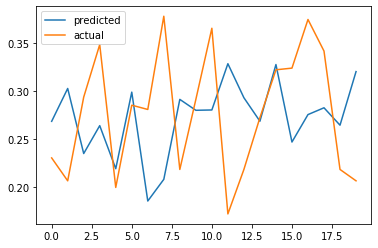

In [32]:
plt.plot(result, label = "predicted")
plt.plot(testTarget.reset_index(drop = True), label = "actual")
plt.legend()

In [15]:
trainTarget.mean()

0.278110500075619

In [16]:
validTarget.mean()

0.2419581414694552